
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## GeostatsPy: Spatial Bootstrap


### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### A Demonstration of Spatial Boostrap 

Here's a simple workflow to demonstrate spatial bootstrap and to compare with regular (non-spatial) bootstrap.

The workflow steps:

1. Build an initial sample set with $ndata$ samples.  Specify locations.  Sort the data in a data only array for 
   an equal weighted cumulative density function (CDF) for backtransform
2. Calculate the covariance matrix (between the data) for LU simulation.  This provides a fast and easy method
   to calculate spaitally correlated, unconditional, Gaussian realizations at the data locations.
3. Perform LU (lower upper) decomposition of the covariance matrix.  Realizations only require L x random vector.
4. Draw from this initial sample set, with replacement, $ndata$ times to build a new realization of the sample.  
   Repeat this $nreal$ times to make realizations of the sample.  Use LU simulation to ensure spaital correlation 
   between samples.  Backtransform from Gaussian to original data values (use percentiles to sample).
5. Calculate the statistic of interest for each realization. This demonstration considers the mean only.  
   We could have considered any statistic including median, 13th percentile, skew etc. 
6. (and 7.) Quantify and visualize uncertainty with histograms and summary statistics.

References:

Efron, 1982, The jackknife, the bootstrap, and other resampling plans, Society of Industrial and Applied Math, 
CBMS-NSF Monographs, 38.

Journel, A. G. Resampling from stochastic simulations. Environmental and Ecological Statistics, 1:63–84, 1994.

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data.csv at https://git.io/fh4gm.

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import os                                               # to set current working directory 
import sys                                              # supress output to screen for interactive variogram modeling
import io
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from matplotlib.pyplot import cm                        # color maps
from matplotlib.patches import Ellipse                  # plot an ellipse
import math                                             # sqrt operator
import scipy
import scipy.linalg                                     # SciPy Linear Algebra Library
from scipy.stats import norm                            # Gaussian distribution

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [2]:
os.chdir("c:/PGE383")                                   # set the working directory

#### Assume Data Values and Locations

For a simple demonstration we assume 4 data values in 2D and make a CDF by sorting

* We will use the CDF for the back transform from Gaussian space.

The user specified data set:

  X    Y    Value
[[25.  50.   2.3]
 [75.  80.   5.5]
 [10.  25.   1. ]
 [95.  15.   8.7]
 [25.  53.   3.7]
 [34.  81.   7.1]
 [72.  68.   8.2]
 [ 9.  13.   5.4]
 [95.  92.   6.2]
 [58.  32.   2.2]]

The data empirical CDF assuming known tails:


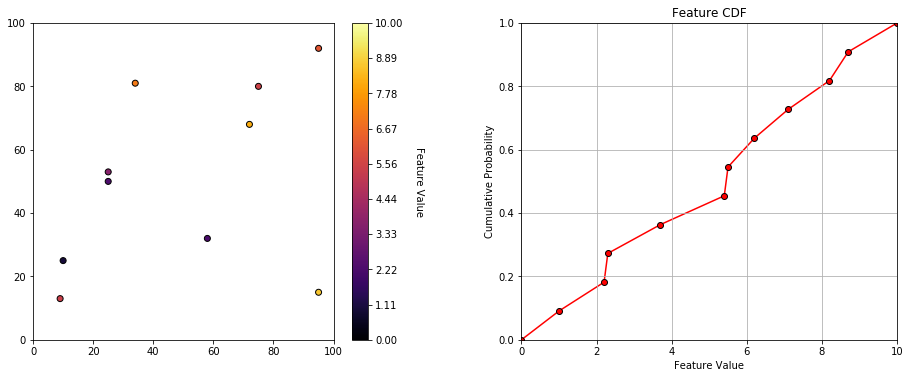

In [11]:
ndata = 10                                              # number of data
vmin = 0.0; vmax = 10.0                                 # assume min and max values

data = np.zeros((ndata,3))                              # x, y, value 
data[0,0] = 25.0;  data[0,1] = 50.0;  data[0,2] = 2.3   # data 1
data[1,0] = 75.0;  data[1,1] = 80.0;  data[1,2] = 5.5   # data 2
data[2,0] = 10.0;  data[2,1] = 25.0;  data[2,2] = 1.0   # data 3
data[3,0] = 95.0;  data[3,1] = 15.0;  data[3,2] = 8.7   # data 4
data[4,0] = 25.0;  data[4,1] = 53.0;  data[4,2] = 3.7   # data 5
data[5,0] = 34.0;  data[5,1] = 81.0;  data[5,2] = 7.1   # data 6
data[6,0] = 72.0;  data[6,1] = 68.0;  data[6,2] = 8.2   # data 7
data[7,0] = 9.0;   data[7,1] = 13.0;  data[7,2] = 5.4   # data 8
data[8,0] = 95.0;  data[8,1] = 92.0;  data[8,2] = 6.2   # data 9
data[9,0] = 58.0;  data[9,1] = 32.0;  data[9,2] = 2.2   # data 9

print('The user specified data set:\n')
print('  X    Y    Value')
print(data) 

cum_prob = np.zeros(ndata+2)                            # calculate the CDF (piece-wise linear)
var = np.zeros(ndata+2)
var[0] = vmin; var[ndata+1] = vmax
cum_prob[0] = 0.0; cum_prob[ndata+1] = 1.0
for i in range(1, ndata+1):
    var[i] = data[i-1,2] 
    cum_prob[i] = i/(ndata+1)
var = np.sort(var)    
    
print('\nThe data empirical CDF assuming known tails:')

plt.subplot(121)
im = plt.scatter(data[:,0],data[:,1],c=data[:,2],vmin=vmin,vmax=vmax,edgecolor='black',cmap=plt.cm.inferno)
plt.xlim([0,100]); plt.ylim([0,100])
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10))
cbar.set_label('Feature Value', rotation=270, labelpad=20)

plt.subplot(122)
plt.plot(var,cum_prob,c='red',zorder=1); plt.xlabel('Feature Value'); plt.xlim([vmin,vmax]); plt.ylim([0.0,1.0])
plt.scatter(var,cum_prob,edgecolor='black',c='red',zorder = 2)
plt.ylabel('Cumulative Probability'); plt.title('Feature CDF'); 
plt.grid(); 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.3, hspace=0.3)
plt.show()

#### Calculate the Covariance Matrix

The data-to-data covariance matrix is calculated from the distance matrix 

* assuming a isotropic spherical variogram with range 

In [19]:
cov = np.zeros((ndata,ndata))                           # covarince matrix initialization
var_range = 100.0                                       # isotropic spherical variogram model range

for i in range(0, ndata):
    for j in range(0, ndata):
        distance = math.sqrt(math.pow((data[i,0]-data[j,0]),2) + math.pow((data[i,1]-data[j,1]),2))
        cova = 0.0
        if(distance < var_range):
            hr = distance / var_range
            cova = 1.0 - hr*(1.5 - 0.5*hr*hr)           # spherical single, isotropic structure, no nugget
            cov[i,j] = cova
            
print('The covariance matrix:\n')
print(np.round(cov,2))

The covariance matrix:

[[1.   0.22 0.58 0.07 0.96 0.53 0.31 0.43 0.05 0.46]
 [0.22 1.   0.03 0.14 0.24 0.42 0.82 0.01 0.66 0.3 ]
 [0.58 0.03 1.   0.03 0.54 0.2  0.08 0.82 0.   0.33]
 [0.07 0.14 0.03 1.   0.06 0.01 0.23 0.03 0.07 0.42]
 [0.96 0.24 0.54 0.06 1.   0.57 0.32 0.39 0.06 0.44]
 [0.53 0.42 0.2  0.01 0.57 1.   0.43 0.1  0.19 0.26]
 [0.31 0.82 0.08 0.23 0.32 0.43 1.   0.04 0.52 0.45]
 [0.43 0.01 0.82 0.03 0.39 0.1  0.04 1.   0.   0.28]
 [0.05 0.66 0.   0.07 0.06 0.19 0.52 0.   1.   0.12]
 [0.46 0.3  0.33 0.42 0.44 0.26 0.45 0.28 0.12 1.  ]]


#### Lower Upper (LU) Decomposition

Peform LU decomposition of the covariance matrix

* calculate the lower matrix $L$ from the covariance matrix.

In [20]:
P, L, U = scipy.linalg.lu(cov)                          # LU decomposition of the covariance matrix
print('The lower matrix:\n')
print(np.round(L,2))

The lower matrix:

[[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.22  1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.58 -0.1   1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.07  0.13  0.01  1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.96  0.03 -0.01 -0.01  1.    0.    0.    0.    0.    0.  ]
 [ 0.53  0.32 -0.12 -0.06  0.62  1.    0.    0.    0.    0.  ]
 [ 0.31  0.79 -0.03  0.12  0.07  0.05  1.    0.    0.    0.  ]
 [ 0.43 -0.1   0.86  0.01 -0.08 -0.05 -0.02  1.    0.    0.  ]
 [ 0.05  0.68  0.06 -0.01 -0.08 -0.06  0.01  0.02  1.    0.  ]
 [ 0.46  0.21  0.13  0.37 -0.   -0.03  0.37  0.1  -0.07  1.  ]]


#### Check the Lower Upper (LU) Decomposition of the Covariance Matrix

We can test the lower upper decomposition by multipling the lower and upper matrices and comparing them to the original covariance matrix.

In [21]:
test = cov - np.matmul(L,U)                             # check result should be close to zero
print('Covariance matrix minus the matrix multiplication of the lower and upper matrices:\n')
print(np.round(test,3))                            

Covariance matrix minus the matrix multiplication of the lower and upper matrices:

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0. -0.  0.  0.  0.  0.]
 [ 0.  0. -0. -0. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0.  0.  0.  0.  0. -0.]
 [ 0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0. -0. -0.  0.  0.  0.]]


#### Calculate Unconditional, Stationary Realizations at the Data Locations 

The following steps:

1. Matrix multiplication of the nxn lower matrix with a 1D matrix of random standard normal values to calculate a realization with spatial correlation at data locations $i = 0,\ldots,n-1$.

2. Convert to p-values with the standard normal CDF

3. Transform to discrete values in the data CDF.

Realizations stored in output.

In [22]:
nreal = 10000                                           # number of bootstrap realizations
spatial_bootstrap = np.zeros((ndata,nreal))             # array to store spatial bootstrap results
for ireal in range(0, nreal):                           # loop over realizations  
    rand = np.random.normal(loc = 0.0, scale = 1.0, size = ndata) # random Gaussian values [ndata]
    realization = np.matmul(L,rand)                     # impose spatial correlation between the values                   
    pvalue = norm.cdf(realization)                      # calculate the p-values
    spatial_bootstrap[:,ireal] = np.interp(pvalue,cum_prob,var,left=None, right=None, period=None) # backtransform ot feature values

#### Visualize Spatial Bootstrap Data Realizations

Let's make some histograms of several spatial bootstrap data realizations.

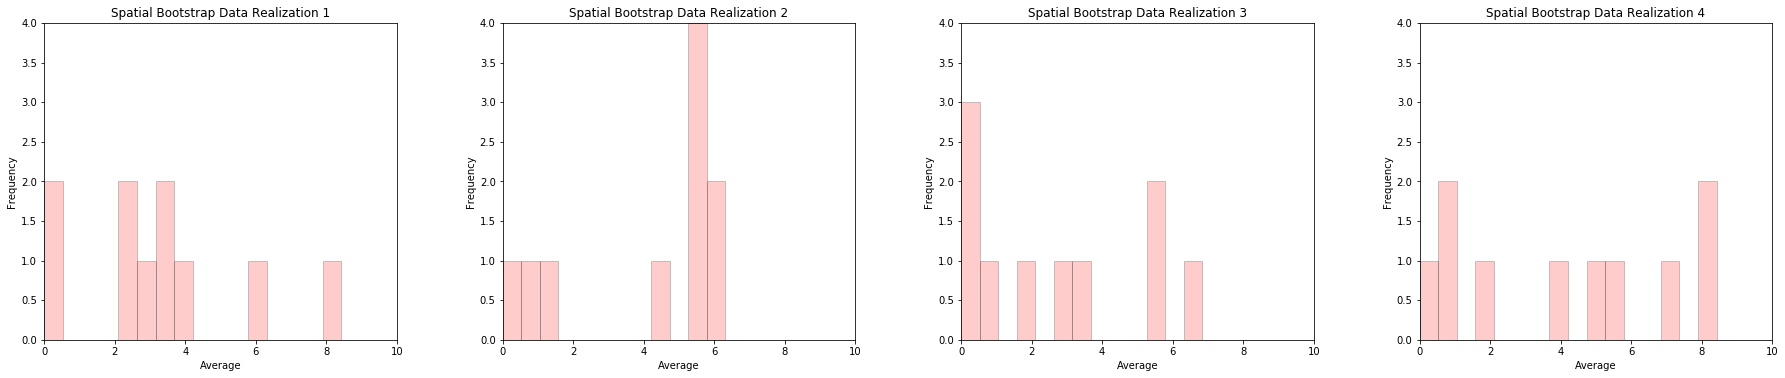

In [23]:
for ix in range(0,4):
    plt.subplot(1,4,ix+1)                               # plot histograms of spatial bootstrap data realizations
    plt.hist(spatial_bootstrap[:,ix],color='red',alpha=0.2,edgecolor='black',bins=np.linspace(vmin,vmax,20))
    plt.xlim([vmin,vmax]); plt.ylim([0,4]); plt.xlabel('Average'); plt.ylabel('Frequency'); plt.title('Spatial Bootstrap Data Realization ' + str(ix+1) + '')

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.1, wspace=0.3, hspace=0.3)
plt.show()

#### Calculate and Summarize the Statistic for Over All Spatial Bootstrap Realizations

Calculate the summary statistic over each spatial bootstrap data realization

* we show the L arithmetic averages calculated over the spatially correlated ndata realizations 

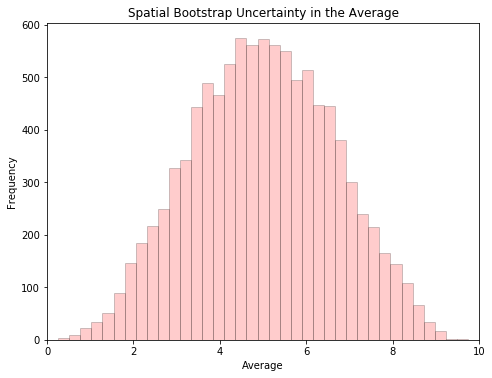

In [24]:
summary_spatial_bootstrap = np.average(spatial_bootstrap,axis=0)
plt.hist(summary_spatial_bootstrap,color='red',alpha=0.2,edgecolor='black',bins=np.linspace(vmin,vmax,40))
plt.xlim([vmin,vmax]); plt.xlabel('Average'); plt.ylabel('Frequency'); plt.title('Spatial Bootstrap Uncertainty in the Average')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.3, hspace=0.3)
plt.show()

#### Calculate and Summarize the Statistic for Over All Regular Bootstrap Realizations and Compare with Spatial Bootstrap

Let's repeat the process with regular bootstrap and compare with our spatial bootstrap results.

* we will work in Gaussian space and backtransform with the data CDF for consistency

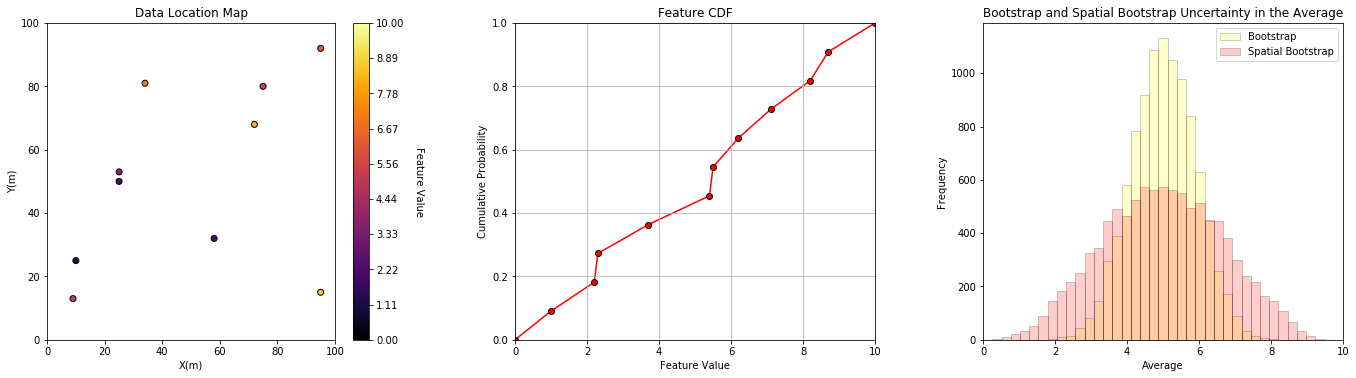

In [25]:
bootstrap = np.zeros((ndata,nreal))                     # array to store spatial bootstrap results
for ireal in range(0, nreal):                           # loop over realizations  
    rand = np.random.normal(loc = 0.0, scale = 1.0, size = ndata) # random Gaussian values [ndata]                  
    pvalue = norm.cdf(rand)                             # calculate the p-values
    bootstrap[:,ireal] = np.interp(pvalue,cum_prob,var,left=None, right=None, period=None)

summary_bootstrap = np.average(bootstrap,axis=0)

plt.subplot(131)
im = plt.scatter(data[:,0],data[:,1],c=data[:,2],vmin=vmin,vmax=vmax,edgecolor='black',cmap=plt.cm.inferno)
plt.xlim([0,100]); plt.ylim([0,100]); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('Data Location Map')
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10))
cbar.set_label('Feature Value', rotation=270, labelpad=20)

plt.subplot(132)
plt.plot(var,cum_prob,c='red',zorder=1); plt.xlabel('Feature Value'); plt.xlim([vmin,vmax]); plt.ylim([0.0,1.0])
plt.scatter(var,cum_prob,edgecolor='black',c='red',zorder = 2)
plt.ylabel('Cumulative Probability'); plt.title('Feature CDF'); 
plt.grid(); 

plt.subplot(133)
plt.hist(summary_bootstrap,color='yellow',alpha=0.2,edgecolor='black',bins=np.linspace(vmin,vmax,40),label='Bootstrap')
plt.hist(summary_spatial_bootstrap,color='red',alpha=0.2,edgecolor='black',bins=np.linspace(vmin,vmax,40),label='Spatial Bootstrap')
plt.legend(loc = 'upper right')
plt.xlim([vmin,vmax]); plt.xlabel('Average'); plt.ylabel('Frequency'); plt.title('Bootstrap and Spatial Bootstrap Uncertainty in the Average')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.3, hspace=0.3)
plt.show()

#### Comments

This was a basic workflow for spatial and regular bootstrap for uncertainty in a samples statistic through sampling multiple data realizations.

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. Also, I have posted a lot of other example workflows and source code to help you get learn about and get work done with **Spatial Data Analytics, Geostatistics and Machine Learning** in Python and R. Check out the [GeostatsGuy Inventory](https://github.com/GeostatsGuy/Resources) and I have a [YouTube](https://youtube.com/GeostatsGuyLectures) channel with all my university lectures recorded.
  
I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)